# Telecom Customer Churn Evaluation

## Work Plan

The telecom company Interconnect has asked the Practicum group to help predict its customers' chances of churning so the company may offer promotions to keep them as a customer. 

This document is the end to end project to create a model designed to predict whether or not customers will decide to cancel their contracts based on a sample of Interconnect's current and past customers.

Table of Contents
1. [Initial Review](#1)  
   1.1 [Contract Dataset](#1.1)  
   1.2 [Internet Dataset](#1.2)  
   1.3 [Personal Dataset](#1.3)  
   1.4 [Phone Dataset](#1.4)  
   1.5 [Initial Review Conclusions](#1.5)  
2. [Preprocessing](#2)  
   2.1 [Contract Dataset](#2.1)  
   2.2 [Internet Dataset](#2.2)  
   2.3 [Personal Dataset](#2.3)  
   2.4 [Phone Dataset](#2.4)  
   2.5 [Preprocessing Conclusions](#2.5)  
3. [Exploratory Data Analysis](#3)  
   3.1 [Visualisation](#3.1)  
   3.2 [Exploratory Data Analysis Conclusions](#3.2)  
4. [Evaluation](#4)  
5. [Model Creation](#5)  
   5.1 [Further Data Preparation](#5.1)  
   5.2 [Model Training](#5.2)  
   5.3 [Model Creation Conclusions](#5.3)  
6. [Conclusion](#6)  

### 1. Initial Review
<a id='1'></a>

First, the data needs to be downloaded and reviewed. This either is done by the zip folder locally extracted to the folder of this notebook file, or is done in the datasets folder of the Practicum's back end directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')


try:
    contract = pd.read_csv('./final_provider/contract.csv')
    internet = pd.read_csv('./final_provider/internet.csv')
    personal = pd.read_csv('./final_provider/personal.csv')
    phone = pd.read_csv('./final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Next, let's look at each dataset at a high level. This includes checking the datatypes, looking at a few observations, and checking if there are null values or duplicates.

To check for duplicates, we have found out that every dataset has a `customerID` column. This is an identifying tag to the customers, so there should only be unique values in this column. As such, we just need to verify that there are indeed only unique values.

In [2]:
def check_duplicates(df):
    """
    Checks if there are duplicate customers.

    Keyword argument:
    df -- the dataframe to check duplicates for (pandas Dataframe)
    """
    
    if len(pd.unique(df.customerID)) == df.shape[0]:
        print('No Duplicates')
    else:
        print('Duplicates')
    
    return 

#### 1.1 Contract Dataset
<a id='1.1'></a>

In [3]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
check_duplicates(contract)

No Duplicates


Under the `contract` dataset, there appears to be no null values or duplicates. There are mixed datetime values and 'No' values in `EndDate` that may become tricky. We can turn the 'No' values to nulls, as pandas let's us manipulate data frequently with the choice of using nulls or not and we will not be giving models datetime types to train on. We will want to create two features however: 
1. the time from beginning to end of a person's contract that has cancelled their service, and this will have to include the active length of the contracts that are still active.
1. a distinctive boolean of whether the contract has been terminated.

The other data features are largely boolean, categorical, and numerical amounts, but they almost all seem to be labelled as object datatypes.

#### 1.2 Internet Dataset
<a id='1.2'></a>

In [5]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
check_duplicates(internet)

No Duplicates


In [7]:
internet.InternetService.value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

The `internet` dataset has no duplicates, but only appears to have 5517 values. This is due to customers only having phone plans, and not having an internet portion of their contract. The `InternetService` is only 2 values and the other features are booleans. We will likely want to make this entire dataset besides the customerID a boolean.

#### 1.3 Personal Dataset
<a id='1.3'></a>

In [8]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
check_duplicates(personal)

No Duplicates


All 7043 customers and their information are accounted for. Similarly to the internet plan, the gender is an either/or categorical feature and the others are yes or no type values. These will be turned into booleans.

#### 1.4 Phone Dataset
<a id='1.4'></a>

In [10]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [11]:
check_duplicates(phone)

No Duplicates


Like the `internet` dataset, the `phone` dataset is a smaller section of the sample, due to what the contract entailed. This dataset, beyond the `customerID`, has one feature that is a boolean that is whether the plan includes multiple lines or not. 

Lastly, lets check to make sure that all of these observations in each dataset are from one sample. 

In [12]:
if personal.customerID.equals(contract.customerID):
    print('All contracts match our personal data')

All contracts match our personal data


In [13]:
if personal.customerID.isin(phone.customerID).sum() == len(phone.customerID):
    print('All phone contracts are accounted for')
    
if personal.customerID.isin(internet.customerID).sum() == len(internet.customerID):
    print('All internet contracts are accounted for')

All phone contracts are accounted for
All internet contracts are accounted for


All of the customers in the contracts are also in the personal information dataset. Additionally, the internet and phone contract customers are also in the personal information dataset.

#### 1.5 Initial Review Conclusions
<a id='1.5'></a>

The datasets seem relatively clean already. There are no duplicates or nulls in any of the datasets, and all of the customers seem to be accounted for. A lot of datatypes will need to be reworked, as a lot of boolean type categories are strings instead. We will take care of this in the next steps.

### 2. Preprocessing
<a id='2'></a>

We know that a large portion of our columns are object datatypes when they should be a boolean value. As such, we will write the following function, `col_to_bool`, to alter columns values and types to True/False boolean values.

In [14]:
def col_to_bool(df, cols, positive, negative):
    '''
    Remaps columns with the same type of 'True/False' distinctions
    
    Keyword arguments:
    df -- the dataframe that the columns are being updated (pandas Dataframe)
    cols -- column names (as strings) that will be updated (list)
    positive -- the positive label that will be remapped to the boolean value True (int or str)
    negative -- the negative label that will be remapped to the boolean value False (int or str)
    '''
    for col in cols:
        df[col] = df[col].map({positive:True, negative:False})
        df[col] = df[col].astype(bool)
    return 

#### 2.1 Contract Dataset
<a id='2.1'></a>

From our initial review, we learned that the only yes or no column in the `contract` dataset was whether or not the customer's contract included paperless billing or not.

In [15]:
col_to_bool(contract, cols=['PaperlessBilling'], positive='Yes', negative='No')
contract.PaperlessBilling.dtype

dtype('bool')

Now we know our function works. Next we want to manipulate the churn information, like the contract dates and whether or not they actually cancelled their accounts as of this information pull.

First, let's turn our `BeginDate` and `EndDate` columns to datetime datatypes. For now, let's force the 'No' values in the `EndDate` column to null values, to make our operations between these dates easier.

In [16]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='raise', format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce', format='%Y-%m-%d')

Now that we have this, we can create our columns depicting the length of the contract and whether or not the customer is considered "churned" or not. 

In [17]:
LengthOfContract = contract['EndDate'] - contract['BeginDate'] # nulls force nulls in the LengthOfContract series as well
Churned = LengthOfContract.notna()
contract.insert(3, 'LengthOfContract', LengthOfContract)
contract.insert(4, 'Churned', Churned)

Now that the cancellation distinction has been made in the new `Churned` column, let's fill in the missing `LengthOfContract` values with the time that this data was pulled.

In [18]:
data_pull = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
contract['LengthOfContract'] = contract['LengthOfContract'].fillna(data_pull - contract.BeginDate)

To finish of this portion of preprocessing, we should turn the datetime days that are the `LengthOfContract` values into integers for our eventual model.

In [19]:
contract['LengthOfContract'] = contract['LengthOfContract'].dt.days
contract.head()

,customerID,BeginDate,EndDate,LengthOfContract,Churned,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,31,False,Month-to-month,True,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,1036,False,One year,False,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,61,True,Month-to-month,True,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,1371,False,One year,False,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,61,True,Month-to-month,True,Electronic check,70.70,151.65


Our `TotalCharges` column is an object, but if we look at the values, we may find out why.

In [20]:
contract['TotalCharges'].value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
493.95      1
418.3       1
6397.6      1
2642.05     1
6093.3      1
Name: TotalCharges, Length: 6531, dtype: int64

there is a value of a single space as a string that is blocking our datatype change. It may be that the charge has not fully gone through yet, as they may be new customers as of this sample creation. Let's verify this.

In [21]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,LengthOfContract,Churned,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,0,False,Two year,True,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,0,False,Two year,False,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,0,False,Two year,False,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,0,False,Two year,False,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,0,False,Two year,False,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,0,False,Two year,False,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,0,False,Two year,False,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,0,False,Two year,False,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,0,False,One year,True,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,0,False,Two year,False,Mailed check,73.35,


In [22]:
contract[contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,LengthOfContract,Churned,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,0,False,Two year,True,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,0,False,Two year,False,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,0,False,Two year,False,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,0,False,Two year,False,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,0,False,Two year,False,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,0,False,Two year,False,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,0,False,Two year,False,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,0,False,Two year,False,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,0,False,One year,True,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,0,False,Two year,False,Mailed check,73.35,


As expected, the contracts with missing Total Charges are the most recent dates we have available, meaning their first payments on their bills may not have occured at the time of this data pull. As they are all one or two year contracts, they are likely willing to go longer than a month since there is a month-to-month option. It would be safe to say that we could populate this with their Monthly Charge amount.

When we downcast the `TotalCharges` and `MonthlyCharges` columns, we can just force the `' '` values to nulls, and then fill the null values with their monthly charges. 

In [23]:
contract['MonthlyCharges'] = pd.to_numeric(contract['MonthlyCharges'], downcast='float')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce', downcast='float')
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges'])

Next, let's create numerical representations of the categorical columns `Type` and `PaymentMethod`. We can achieve this by doing one-hot encoding, so that each category becomes its own column and is represented by a boolean as to whether or not it is the representative characteristic of the contract.

In [24]:
types_oh = pd.get_dummies(contract.Type, prefix='type', drop_first=True).astype(bool)
payments_oh = pd.get_dummies(contract.PaymentMethod, prefix='payment', drop_first=True).astype(bool)

In [25]:
contract = contract.join([types_oh, payments_oh])
contract.drop(['Type', 'PaymentMethod'], axis=1, inplace=True)

Lastly, we identified in the initial review that not all customers have both phone and internet plans. This should be represented in the `contract` dataset as another few booleans.

In [26]:
contract['phone'] = contract.customerID.isin(phone.customerID)
contract['internet'] = contract.customerID.isin(internet.customerID)

In [27]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   customerID                       7043 non-null   object        
 1   BeginDate                        7043 non-null   datetime64[ns]
 2   EndDate                          1869 non-null   datetime64[ns]
 3   LengthOfContract                 7043 non-null   int64         
 4   Churned                          7043 non-null   bool          
 5   PaperlessBilling                 7043 non-null   bool          
 6   MonthlyCharges                   7043 non-null   float32       
 7   TotalCharges                     7043 non-null   float32       
 8   type_One year                    7043 non-null   bool          
 9   type_Two year                    7043 non-null   bool          
 10  payment_Credit card (automatic)  7043 non-null   bool       

,customerID,BeginDate,EndDate,LengthOfContract,Churned,PaperlessBilling,MonthlyCharges,TotalCharges,type_One year,type_Two year,payment_Credit card (automatic),payment_Electronic check,payment_Mailed check,phone,internet
0,7590-VHVEG,2020-01-01,NaT,31,False,True,29.850000,29.850000,False,False,False,True,False,False,True
1,5575-GNVDE,2017-04-01,NaT,1036,False,False,56.950001,1889.500000,True,False,False,False,True,True,True
2,3668-QPYBK,2019-10-01,2019-12-01,61,True,True,53.849998,108.150002,False,False,False,False,True,True,True
3,7795-CFOCW,2016-05-01,NaT,1371,False,False,42.299999,1840.750000,True,False,False,False,False,False,True
4,9237-HQITU,2019-09-01,2019-11-01,61,True,True,70.699997,151.649994,False,False,False,True,False,True,True


The `contract` dataset has now been properly prepared for our exploratory data analysis and model training.

#### 2.2 Personal Dataset
<a id='2.2'></a>

Again, a large portion of the `personal` dataset is either/or data or boolean data. Let's fix this now.

In [28]:
# changing gender to a boolean of whether a customer is female or not
col_to_bool(personal, ['gender'], 'Female', 'Male')
personal.rename(columns={'gender':'Female'}, inplace=True)

# changing the senior citizen from 1/0 to True/False
col_to_bool(personal, ['SeniorCitizen'], '1', '0')

# changing the yes/no values of Partner and Dependents to True/False
col_to_bool(personal, ['Partner', 'Dependents'], 'Yes', 'No')

In [29]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   Female         7043 non-null   bool  
 2   SeniorCitizen  7043 non-null   bool  
 3   Partner        7043 non-null   bool  
 4   Dependents     7043 non-null   bool  
dtypes: bool(4), object(1)
memory usage: 82.7+ KB


,customerID,Female,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,True,True,True,False
1,5575-GNVDE,False,True,False,False
2,3668-QPYBK,False,True,False,False
3,7795-CFOCW,False,True,False,False
4,9237-HQITU,True,True,False,False


As that was the only issue noticed in the data review, the `personal` dataset is properly processed.

#### 2.3 Internet Dataset
<a id='2.3'></a>

A majority of the columns were identified as boolean in nature in the `internet` dataset, so let's fix the datatypes.

In [30]:
col_to_bool(internet, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
                       'StreamingTV', 'StreamingMovies'], 'Yes', 'No')

Similarly to the categorical values in the `contract` dataset, we have a column identifying whether or not a customer has a DSL or Fiber optic connection. 

It is typical to drop the first category during one-hot encoding, to avoid over-weighing a category. Because we know there is technically a third option of neither if a customer does not have an internet plan, we should not drop the first category. If we create a one-hot encoding that only represents if a contract is DSL or not, a contract without an internet plan will be represented similarly to a contract with a Fiber optic plan.

In [31]:
service_type = pd.get_dummies(internet.InternetService, prefix='service_type', drop_first=False).astype(bool)
internet = internet.join([service_type])
internet.drop('InternetService', axis=1, inplace=True)
internet.head()

,customerID,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,service_type_DSL,service_type_Fiber optic
0,7590-VHVEG,False,True,False,False,False,False,True,False
1,5575-GNVDE,True,False,True,False,False,False,True,False
2,3668-QPYBK,True,True,False,False,False,False,True,False
3,7795-CFOCW,True,False,True,True,False,False,True,False
4,9237-HQITU,False,False,False,False,False,False,False,True


The `internet` dataset is now cleaned for training.

#### 2.4 Phone Dataset
<a id='2.4'></a>

Lastly, the `phone` dataset is simply a Yes/No column that needs to be represented as a boolean.

In [32]:
col_to_bool(phone, ['MultipleLines'], 'Yes', 'No')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,False
1,3668-QPYBK,False
2,9237-HQITU,False
3,9305-CDSKC,True
4,1452-KIOVK,True


#### 2.5 Preprocessing Conclusions
<a id='2.5'></a>

The datasets have been manipulated both to create new features necessary to represent untrainable data as well as optimize datatypes to improve model training speed.

All of our data now is prepared to be explored visually and trained in our model.

### 3 Exploratory Data Analysis
<a id='3'></a>

#### 3.1 Visualisation
<a id='3.1'></a>

When looking at our data visually, we mostly care about the cancelled contracts versus the ongoing one, so let's split the dataset along our churn value.

In [33]:
churned = contract[contract.Churned == True]
not_churned = contract[contract.Churned == False]
print(churned.shape)
print(not_churned.shape)

(1869, 15)
(5174, 15)


We definitely have a lot more customers in our set that have kept their contracts than the number of customers that have cancelled them. Let's now try and see if customers tend to cancel after a certain time on their contract. If we look at the length of the contract, we may get some insight into this.

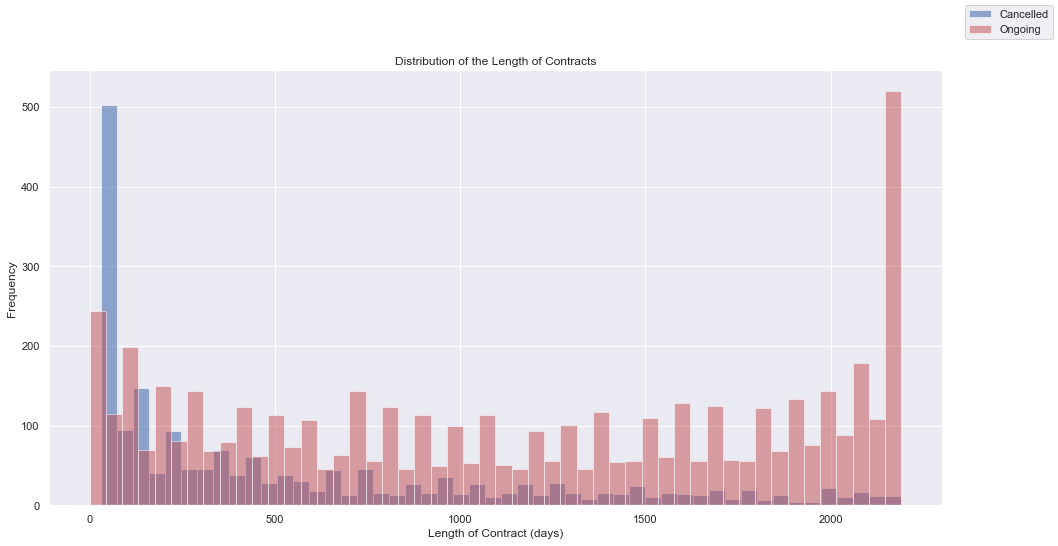

In [34]:
fig_loc = plt.figure(figsize=(16,8));
churned.LengthOfContract.hist(bins=50, alpha=0.6, color='b');
not_churned.LengthOfContract.hist(bins=50, alpha=0.5, color='r');
fig_loc.legend(labels=['Cancelled', 'Ongoing'])
plt.title('Distribution of the Length of Contracts');
plt.xlabel('Length of Contract (days)')
plt.ylabel('Frequency')
plt.show()



It does appear that the majority of cancellations happen within the customer's first 365 days of their contract. This means that this timeframe must be pretty critical where the customer is really deciding if the Interconnect contract is something that they would like to continue using. After one year, it seems to trail pretty low, where they had likely decided that the service is something they want to continue. These few customers could have dropped for anything, such as moving, and may be harder to persuade back into the service. 

We can also see that those who have not yet churned have been steadily onboarded, as these contracts are since their start date up to February 1, 2020. It is also nice to see that there is a significant amount of folks that have been long time users of the Interconnect services. 

Next, Let's see how much the contract type may affect the customer's chances of churning.

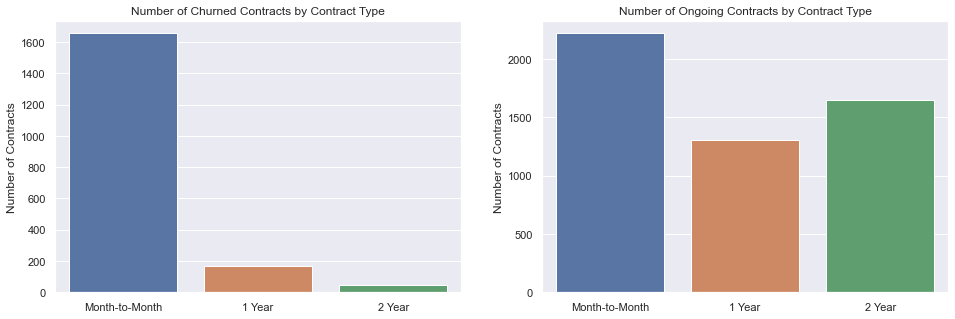

In [35]:
fig_con, axes = plt.subplots(1,2, figsize=(16,5))
y1 = [churned.shape[0]-(churned['type_One year'].sum()+churned['type_Two year'].sum()),
      churned['type_One year'].sum(),
      churned['type_Two year'].sum()]
y2 = [not_churned.shape[0]-(not_churned['type_One year'].sum()+not_churned['type_Two year'].sum()),
      not_churned['type_One year'].sum(),
      not_churned['type_Two year'].sum()]

sns.barplot(x=['Month-to-Month', '1 Year', '2 Year'], y=y1, ax=axes[0])
sns.barplot(x=['Month-to-Month', '1 Year', '2 Year'], y=y2, ax=axes[1]);
axes[0].set_title('Number of Churned Contracts by Contract Type')
axes[0].set_ylabel('Number of Contracts')
axes[1].set_title('Number of Ongoing Contracts by Contract Type')
axes[1].set_ylabel('Number of Contracts')
plt.show()

Month-to-month clearly is the majority of customers' contract of choice that have terminated their contract. These customers likely chose month-to-month in the first place, as they were unsure of the services that Interconnect provides. Likely in the Interconnect terms of service, it is easier to break out of a month-to-month contract than it is for a 1 year or 2 year contract. The customers that do not churn are more likely to get on 1 year or 2 year contracts.

Similarly, let's check the payment type and see if that has an effect.

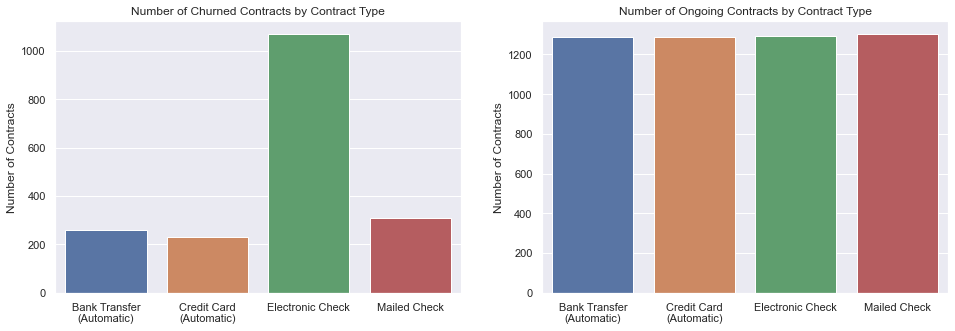

In [36]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
y1 = [churned.shape[0]-(churned['payment_Credit card (automatic)'].sum()+churned['payment_Electronic check'].sum()+churned['payment_Mailed check'].sum()),
      churned['payment_Credit card (automatic)'].sum(),
      churned['payment_Electronic check'].sum(),
      churned['payment_Mailed check'].sum()]
y2 = [not_churned.shape[0]-(not_churned['payment_Credit card (automatic)'].sum()+not_churned['payment_Electronic check'].sum()+not_churned['payment_Mailed check'].sum()),
      not_churned['payment_Credit card (automatic)'].sum(),
      not_churned['payment_Electronic check'].sum(),
      not_churned['payment_Mailed check'].sum()]

sns.barplot(x=['Bank Transfer\n(Automatic)', 'Credit Card\n(Automatic)', 'Electronic Check', 'Mailed Check'], y=y1, ax=axes[0])
sns.barplot(x=['Bank Transfer\n(Automatic)', 'Credit Card\n(Automatic)', 'Electronic Check', 'Mailed Check'], y=y2, ax=axes[1]);
axes[0].set_title('Number of Churned Contracts by Contract Type')
axes[0].set_ylabel('Number of Contracts')
axes[1].set_title('Number of Ongoing Contracts by Contract Type')
axes[1].set_ylabel('Number of Contracts')
plt.show()

Churned customers are more likely to use electronic checks. If the process to send in an electronic check is tedious through Interconnect's payment system, customers may be turned off to the services. Automatic type payments are understandably less hands on, and customers may not think twice about their services if they don't play an active part in paying for the services. 
Ongoing contracts are much more evenly spread, including electronic checks.

Lastly, the amount a customer is charged will likely affect their decision to stay on the contract. One might presume a customer paying a large amount would be more inclined to second guess if they really need the service, so let's have a look at that.

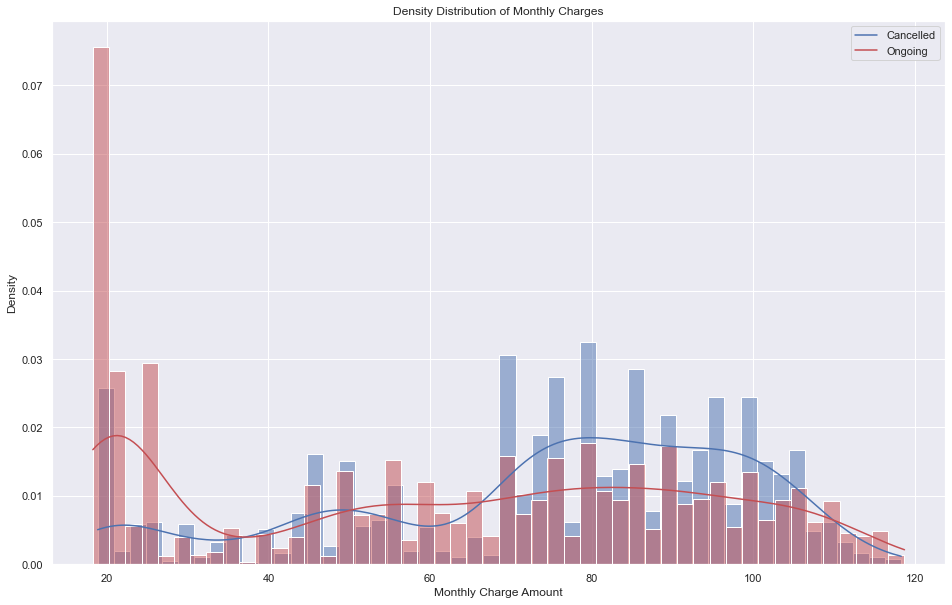

In [37]:
fig_mc = plt.figure(figsize=(16, 10))
sns.histplot(churned.MonthlyCharges, bins=50, kde=True, stat='density', color='b')
sns.histplot(not_churned.MonthlyCharges, bins=50, kde=True, stat='density', color='r');
plt.title('Density Distribution of Monthly Charges')
plt.xlabel('Monthly Charge Amount')
plt.ylabel('Density')
plt.legend(labels=['Cancelled', 'Ongoing'])
plt.show()

As expected, the cancelled contracts were more inclined to pick up more expensive monthly bills, upwards in the 80 to 100 range. Ongoing contracts were across the board, but were overwhelmingly near 20. Maybe this is those happy long time users we saw before.

#### 3.2 Exploratory Data Analysis Conclusions
<a id='3.2'></a>

From our visual representation of the data, there are already some distinct features about our churned customers. We see that they are typically out of the contract within the first year of the contract. They also tend to be customers who may add more services or pick packages that increase their monthly charges to maybe a level that they decide is too much for their current financial situation to continue. They also tend to choose the month-to-month plan which is easier to leave as is. This likely represents an initial hesitancy of the services to begin with. Lastly, electronic checks seem to be a common payment method for churned customers. This may be a more frustrating process than the company thinks and could cause some folks on the fence to jump off towards cancelling their plan.

### 4 Evaluation
<a id='4'></a>

The model we will create will be evaluated on the AUC-ROC of the predictions. As this is a binary classification problem, the AUC-ROC is one of the best ways to evaluate the predictions. The AUC-ROC is the superstar evaluation as it evaluates classifications in scenarios designed to maximize correct positive calculations while limiting false, positive classifications (type 1 errors). 

We also will want to make sure we get a reasonable accuracy score. Accuracy is a good baseline of a good model, as ultimately we want to make sure we are making accurate predictions for all data that comes our way. If Accuracy is poor, it should not matter what the AUC-ROC is because we will need to reevaluate our model if it can't generally predict customers that may drop their contract.

Lastly, we should look at the confusion matrix. The confusion matrix is a representation of the true-positive, true-negative, false-positive, and false-negative predictions. This way, if we get a good AUC-ROC and good accuracy score, but we have trouble specifically generating a lot of false-positive values, we may making incorrect decisions, and say giving promotions to people who may not actually be planning on leaving.

With all of this in mind, we should create a function to check these evaluation metrics.

In [38]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    '''
    This will take our model and data and generate the evaluation metrics that we desire 
    (AUC-ROC, accuracy, and the confusion metric)
    
    Keyword arguments:
    model -- The model that has already been trained by the training data (a Binary Classifier)
    train_features -- The features used to train the model (dataframe)
    train_target -- The target used to train the model (series)
    test_features -- The features used to test the model (dataframe)
    test_target -- The target used to test the model (series)
    '''
    
    # Where our AUC-ROC and accuracy will be stored for the training and test set
    eval_stats = {}
    
    # Subplot for AUC-ROC and confusion matrix
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
    
    # Plot training and test AUC-ROC curves on the same plot
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        
        # Some models tend to create the True/False labels as strings rather than boolean, so this is meant
        # to check and fix if necessary.
        if isinstance(pred_target[0], str):
            pred_target = [True if x == 'True' else 'False' for x in pred_target]
        pred_proba = model.predict_proba(features)[:, 1]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['AUC-ROC'] = roc_auc
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'
            
        
        
        # ROC
        ax = axs[0]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, AUC-ROC={roc_auc:.4f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')   

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    # Confusion Matrix
    ax = axs[1]
    
    c_matrix = metrics.confusion_matrix(target, pred_target)
    
    # Lebel descriptions on each block of the matrix as the descriptor, number of values, and percentage of the whole dataset
    type_labels = ['TN', 'FP', 'FN', 'TP']
    actual_count = ['{:.0f}'.format(value) for value in c_matrix.flatten()]
    perc_count = ['{:.2%}'.format(value) for value in c_matrix.flatten()/sum(c_matrix.flatten())]
    group_labels = [f'{name}\n{num}\n{perc}' for name, num, perc in zip(type_labels, actual_count, perc_count)]
    group_labels = np.array(group_labels).reshape(2,2)
    
    sns.heatmap(c_matrix, annot=group_labels, fmt='', cbar=False, cmap='binary', ax=ax)
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('True Value')
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'AUC-ROC'))
    
    print(df_eval_stats)
    
    return 

Now that we have the evaluation statistics creation, let's use it on some models.

### 5 Model Creation
<a id='5'></a>

#### 5.1 Further Data Preparation
<a id='5.1'></a>

Before we can create the model and train it, we need to combine our data into one set of features, so let's combine the datasets. We can combine them off of the customer ID numbers, as those are identifiers for all sets. We know that the phone and internet contracts use boolean features of whether certain parts of Interconnect's services are a part of the contract. Therefore, we know that if someone does not have an internet contract at all, then they would have none of the individual services in an internet contract. Let's then fill the created null values from the internet and phone datasets with False values.

In [39]:
contract.set_index('customerID', inplace=True)
internet.set_index('customerID', inplace=True)
phone.set_index('customerID', inplace=True)
personal.set_index('customerID', inplace=True)
full_set = contract.join([internet, phone, personal])
full_set.fillna(False, inplace=True)

Models typically only train on numerical data or booleans, and it won't train on datetime values. While it was nice to use in our earlier manipulation, we need to remove it when we create our features set and or target. We also will want to drop the Total Charges. Total Charges is dependent on the Monthly Charge extrapolated over the contract length. Although there may be small variances such as fees, over the timeframes of these contracts, the variances would have a minor effect.

In [40]:
features = full_set.drop(['BeginDate', 'EndDate', 'Churned', 'TotalCharges'], axis=1)
target = full_set.Churned

Next, let's split our data so we can have a proper valid set to evaluate our data, and a test set to get final metrics.

In [41]:
X_train, X_check, y_train, y_check = train_test_split(features, target, test_size=0.50, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_check, y_check, test_size=0.50, random_state=12345)

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(3521, 23)
(3521,)
(1761, 23)
(1761,)
(1761, 23)
(1761,)


No lost information, and it look's like a correct 50/25/25 split.

As we noted previously, the number of ongoing contracts greatly outnumber the amount of cancelled contracts in our sample. Therefore, we should create a set of training data that balances the imbalanced observations. Then we can compare to see how much this helped our models' predictive capabilities.

In [43]:
sample_boost = SMOTE()
X_train_b, y_train_b = sample_boost.fit_resample(X_train, y_train)

#### 5.2 Model Training
<a id='5.2'></a>

First, Let's create a binary classifier using LightGBM, a high performing and fast training Gradient Boosting model framework. Gradient Boosting is a form of ensemble modelling, where it evaluates the losses of the previously run tree to the next tree that will be trained, and determines the gradient of which the losses have diminished by in each subsequent tree.

Let's use the same parameters for two models, and only distinguish the two by using the imbalanced or balanced data.

In [44]:
params = {'boosting_type': 'gbdt',
          'learning_rate': 0.1,
          'max_depth': 100,
          'n_estimators': 100,
          'num_leaves': 20,
          'objective': 'binary',
          'random_state': 12345,
          'metric': 'binary_logloss',
          'silent': True}

clf1 = lgb.LGBMClassifier(**params).fit(X_train, y_train);
clf1_b = lgb.LGBMClassifier(**params).fit(X_train_b, y_train_b);

Now that the models are created, we can use our evaluation function on both training sets.

          train  test
Accuracy   0.90  0.83
AUC-ROC    0.97  0.88


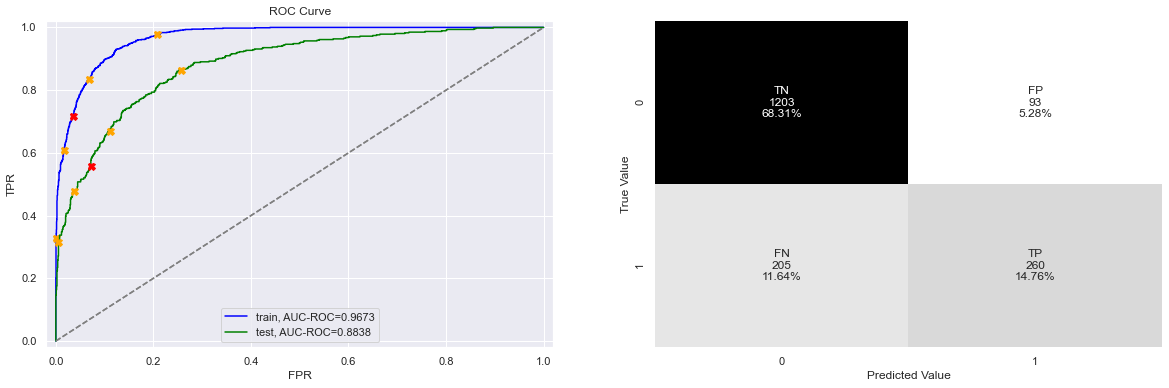

In [45]:
evaluate_model(clf1, X_train, y_train, X_valid, y_valid)

          train  test
Accuracy   0.94  0.84
AUC-ROC    0.99  0.88


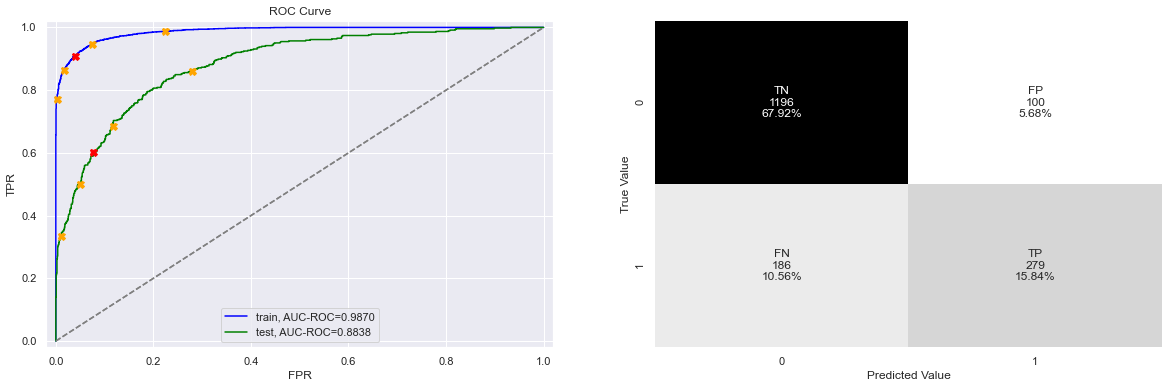

In [46]:
evaluate_model(clf1_b, X_train_b, y_train_b, X_valid, y_valid)

It seems that balancing the data didn't help as much as we may have expected--certainly not on this model. Accuracy and AUC-ROC scores stayed the same, and the confusion matrix didn't really improve, but rather showed us that the model slightly focused more on getting the True Positive predictions correct.

Now, we should attempt increasing the learning rate, so that we may avoid getting trapped in local minimas. Also, let's increase the number of estimators and leaves of each tree, so that we can get further learning from each estimator, as well as more estimators to evaluate from.

In [47]:
params = {'boosting_type': 'gbdt',
          'learning_rate': 0.3,
          'max_depth': 100,
          'n_estimators': 200,
          'num_leaves': 30,
          'objective': 'binary',
          'random_state': 12345,
          'metric': 'binary_logloss',
          'silent': True}

clf2 = lgb.LGBMClassifier(**params).fit(X_train, y_train);
clf2_b = lgb.LGBMClassifier(**params).fit(X_train_b, y_train_b);

          train  test
Accuracy    1.0  0.85
AUC-ROC     1.0  0.88


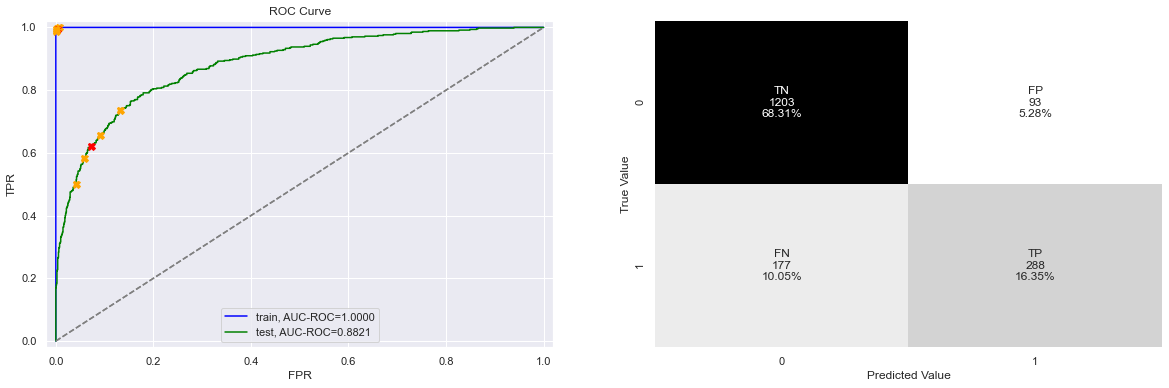

In [48]:
evaluate_model(clf2, X_train, y_train, X_valid, y_valid)

          train  test
Accuracy    1.0  0.85
AUC-ROC     1.0  0.89


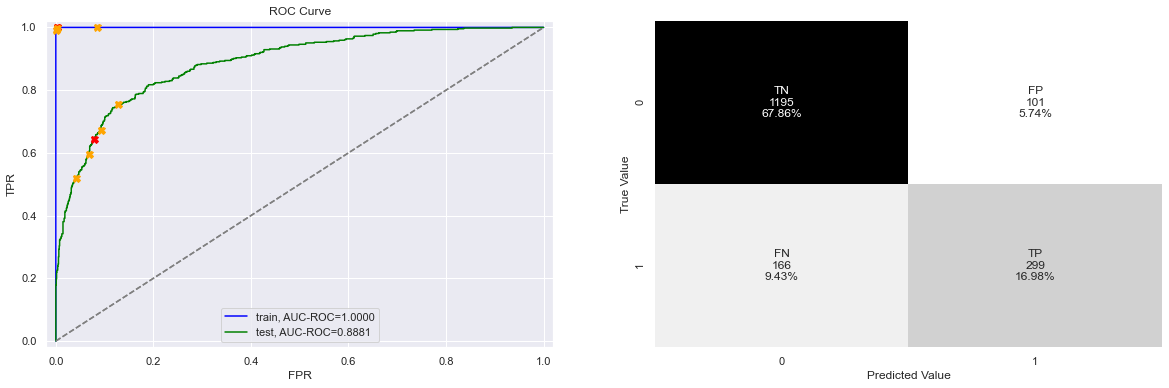

In [49]:
evaluate_model(clf2_b, X_train_b, y_train_b, X_valid, y_valid)

The AUC-ROC of the SMOTE boosted model only marginally went up, but our accuracy went down. The confusion matrix did not really change all that much either. We would likely still call this our best model however, as the AUC-ROC was our main evaluation. As this model was the best performing, let's check it with our test dataset.

          train  test
Accuracy    1.0  0.84
AUC-ROC     1.0  0.89


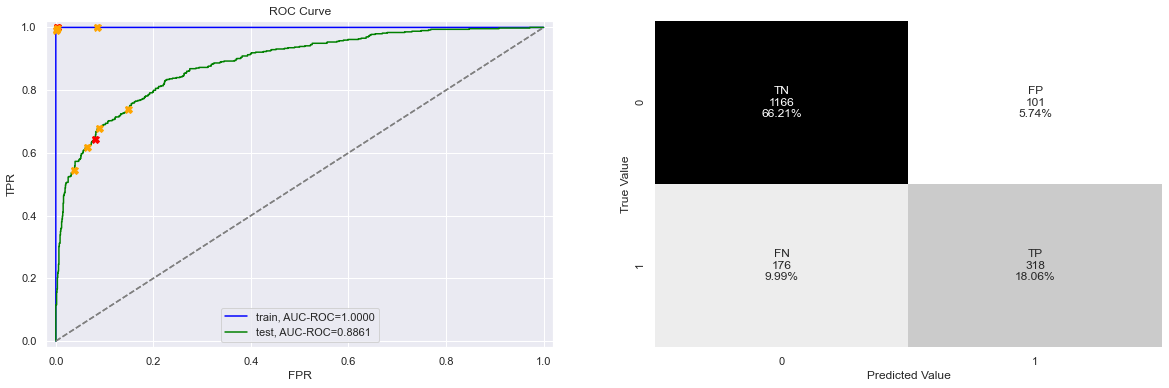

In [50]:
evaluate_model(clf2_b, X_train_b, y_train_b, X_test, y_test)

An AUC-ROC score of 89%, an accuracy score of 85%, and a relatively acceptable confusion matrix came from our best model that was tested by the validation set and then finalized on our test set.

Let's look into the LightGBM's attribute `feature_importances_` to understand what factored most into the model's decisioning process to label customer's potential to cancel.

In [51]:
importance = pd.Series(clf2.feature_importances_, index=features.columns)
importance.sort_values(ascending=False)

LengthOfContract                   2064
MonthlyCharges                     1990
Female                              236
Partner                             166
payment_Electronic check            158
PaperlessBilling                    141
OnlineBackup                        111
Dependents                          108
DeviceProtection                    105
MultipleLines                       104
payment_Mailed check                 81
OnlineSecurity                       79
payment_Credit card (automatic)      76
StreamingMovies                      76
TechSupport                          70
type_One year                        65
StreamingTV                          61
type_Two year                        36
phone                                33
service_type_Fiber optic             19
service_type_DSL                     12
internet                              9
SeniorCitizen                         0
dtype: int32

As expected, Length of Contract and Monthly Charges were extremely important during training. After those features, gender and relationship status were the most crucial, but by a much slimmer margin. These and the other features are somewhat of a plateau in terms of importance to the modelling.

#### 5.3 Model Creation Conclusions
<a id='5.3'></a>

The models we created performed successfully, and excelled on all of our evaluation metrics. Balancing our data only marginally helped, but most importantly it helped the models focus a little more on the customers who may actually churn. This comes at the cost of predicting more people would churn even if they still had an ongoing contract. When we increased the speed that the ensemble model learned the losses from, increased the number of estimators, and increased the number of leaves that the decision trees learned with, we got our best results with an AUC-ROC score of 0.89 and an accuracy of 0.85. Our confusion matrix was reassuring, as there were no standouts in the models ability to predict either churned customers or ongoing customers. 

## Final Conclusions
<a id='6'></a>

This project was conducted as a response to a request from the telecom company Interconnect. They requested help to predict whether or not a customer would cancel their contract, so they may be able to attempt to retain them with promotions. The above jupyter notebook was the code and description that lead to a model with a strong ability to predict these customers for Interconnect. We were provided information on over 7000 customers by Interconnect, containing information about:

1. their personal information (non-identifying),
1. their contract information,
1. their internet plan services (if applicable),
1. and their phone plan services (if applicable.

The initial review and preprocessing were done in accordance to the work plan outlined in the Telecom Work Plan document. The issues found in the work plan, such as mismatched datatypes, were cleaned to visualize and to train our model with. Although we found no nulls, we did find some empty values in the form of a string for recent contract signers that would yet to be charged. As such, we cleaned the data, and created a few new features to represent our length of contract and a boolean of whether or not a customer has cancelled a contract or not.

We did not leave in the distributions that were in the work plan, as they were largely used to confirm that this was a diverse group on customers and contracts, so that a model would have a wider range of information to train on. With the plots above, we found that churned customers are typically out of the contract within the first year of the contract. We noticed that they tend to be customers who may add more services or pick packages that increase their monthly charges to maybe a level that they decide is too much for their current financial situation to continue. They also tend to choose the month-to-month plan which is easier to cancel. This likely represents an initial hesitancy of the services to begin with. Lastly, electronic checks were a common payment method for churned customers. Initially, we thought this might mean Interconnect has an electronic check system that may not be user friendly to it's customers.

We then created our evaluation function that created metrics and graphical representation of our models. Our work plan initially said that the AUC-ROC score of a model would be the sole evaluation metric. Although it was our focus, we also included the accuracy and confusion matrix, to make sure that in general we were still predicting a fair amount of customers and that we weren't mislabeling one of the two possibilities in particular. The data was then split into features and a target, and a duplicate set was balanced so that the smaller number of churned samples may carry more importance during training. 

Finally, a few models were created. Balancing the training data and allowing each decision tree of the ensemble have deeper and wider branches produced the best model of the four that were tested. Initially, there were issues in the data preparation for this stage. At first, the target was left in the features, skewing the results positively when the target is not supposed to be known. Addeitionally, when balancing the data with SMOTE, the test data was first balanced as well, which was not correct. only the training data should be balanced, because the test data is still meant to be representative of an actual scenario of a group of customers and their contracts, while boosting the data is only an attempt to give a model more focus on the lesser available data. 

Using the LightGBM Gradient Boosting API, we successfully got an AUC-ROC score of 89%, an accuracy of 85%, and a promising confusion matrix with only a small percentage of evenly incorrect predictions for both churned and non-churned customers. From this model, we looked into the its generated list of feature importances, or the general weight it holds on the prediction. We noticed that, as we expected from our visualisation, that the length of a contract and the monthly charges were the biggest factors in a person's chances of cancelling a contract. Although the month-to-month and electronic check importance were not very high, this may be the result of data leakage from the length of a contract, and they may share related characteristics.